In [25]:
!pip install geostatspy
!pip install scikit-gstat
!pip install pyproj
!pip install geopandas
!pip install contextily
!pip install pointpats


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import rasterio

# Ruta relativa al archivo dentro de Colab
file_path = '/content/drive/MyDrive/Colab_Notebooks/HillshadeMosaic_Daylight.tif'

# Abre el archivo raster
with rasterio.open(file_path) as file:
    # Lee los datos del archivo raster
    dataset = file.read()

# Imprime la forma de los datos del raster
print(dataset.shape)


(1, 14559, 22690)


In [26]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import geostatspy.GSLIB as GSLIB;
import geostatspy.geostats as geostats;
from scipy.spatial.distance import cdist;
from skgstat import Variogram, OrdinaryKriging;
from sklearn.metrics import pairwise_distances;
from sklearn.preprocessing import StandardScaler;
from sklearn.neighbors import DistanceMetric;
from sklearn.preprocessing import StandardScaler;
from sklearn.gaussian_process import GaussianProcessRegressor;
from sklearn.gaussian_process.kernels import RBF;
from sklearn.impute import SimpleImputer;
import pyproj;
import geopandas as gpd;
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [20]:
# Leer el archivo de Excel y almacenar los datos en el objeto "data"
data = pd.read_excel('datos_au_cu.xlsx');

# Calcular estadísticas descriptivas de la columna 'Cu_ppm' y almacenarlas en el objeto "cobre"
cobre = data['Cu_ppm'].describe();

# Calcular estadísticas descriptivas de la columna 'Mo_ppm' y almacenarlas en el objeto "molibdeno"
molibdeno = data['Mo_ppm'].describe();
# Mostrar las primeras filas del DataFrame "data"
data.head()


,Coord_X,Coord_Y,Cu_ppm,Au_ppm,Mo_ppm
0,-75.463050,5.587048,91.0,0.2,0.22
1,-75.485565,5.588088,17.2,0.2,4.12
2,-75.482058,5.589082,4.5,0.5,0.31
3,-75.492636,5.590230,49.3,0.2,0.13
4,-75.477046,5.591065,252.0,0.3,0.69


In [21]:
print(molibdeno);

count    351.000000
mean       1.074086
std        2.715629
min        0.030000
25%        0.190000
50%        0.410000
75%        0.830000
max       35.700000
Name: Mo_ppm, dtype: float64


In [22]:
print(cobre);

count    351.000000
mean      54.538640
std       94.426667
min        0.430000
25%        5.240000
50%       24.800000
75%       65.917500
max      885.800000
Name: Cu_ppm, dtype: float64


In [23]:
# Extraer la columna "Coord_X" del DataFrame "data" y almacenarla en el objeto "Coord_X"
Coord_X = data["Coord_X"]

# Extraer la columna "Coord_Y" del DataFrame "data" y almacenarla en el objeto "Coord_Y"
Coord_Y = data["Coord_Y"]

# Extraer la columna "Cu_ppm" del DataFrame "data" y almacenarla en el objeto "Cu_ppm"
Cu_ppm = data["Cu_ppm"]

Mo_ppm= data["Mo_ppm"]


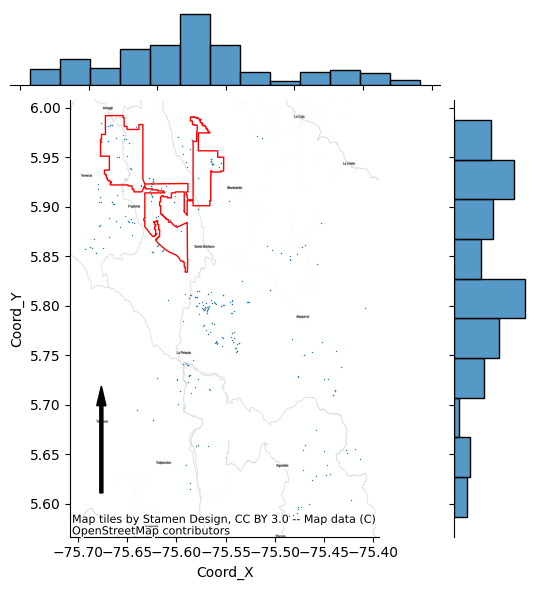

In [75]:
import seaborn as sbn
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt


# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Leer el archivo shapefile
mtbll_nal = gpd.read_file(ruta_shp)
mtbll_nal = mtbll_nal.to_crs("EPSG:4326")
# Crear un GeoDataFrame a partir de los datos

joint_axes = sbn.jointplot(x='Coord_X', y='Coord_Y', data=data, s=1)

# Obtener los límites de los ejes
x_min, x_max = joint_axes.ax_joint.get_xlim()
y_min, y_max = joint_axes.ax_joint.get_ylim()

# Agregar el mapa base como una imagen detrás de la gráfica
ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.Stamen.TonerLite,
    alpha=1.0,
    zoom=12
)

# Agregar flecha que indica el norte
ax = joint_axes.ax_joint
ax.arrow(0.1, 0.1, 0, 0.2, width=0.01, transform=ax.transAxes, color='black')

# Restaurar los límites de los ejes
joint_axes.ax_joint.set_xlim(x_min, x_max)
joint_axes.ax_joint.set_ylim(y_min, y_max)

# Mostrar el gráfico
plt.imshow(joint_axes.ax_joint.get_images()[0].get_array(), extent=(x_min, x_max, y_min, y_max), aspect='auto')

# Guardar la gráfica en la unidad de Google Drive

mtbll_nal.plot(ax=ax, facecolor='none', edgecolor='red')

plt.show()




In [76]:
from pointpats import centrography

In [77]:
mean_center = centrography.mean_center(data[['Coord_X', 'Coord_Y']])
med_center = centrography.euclidean_median(data[['Coord_X', 'Coord_Y']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


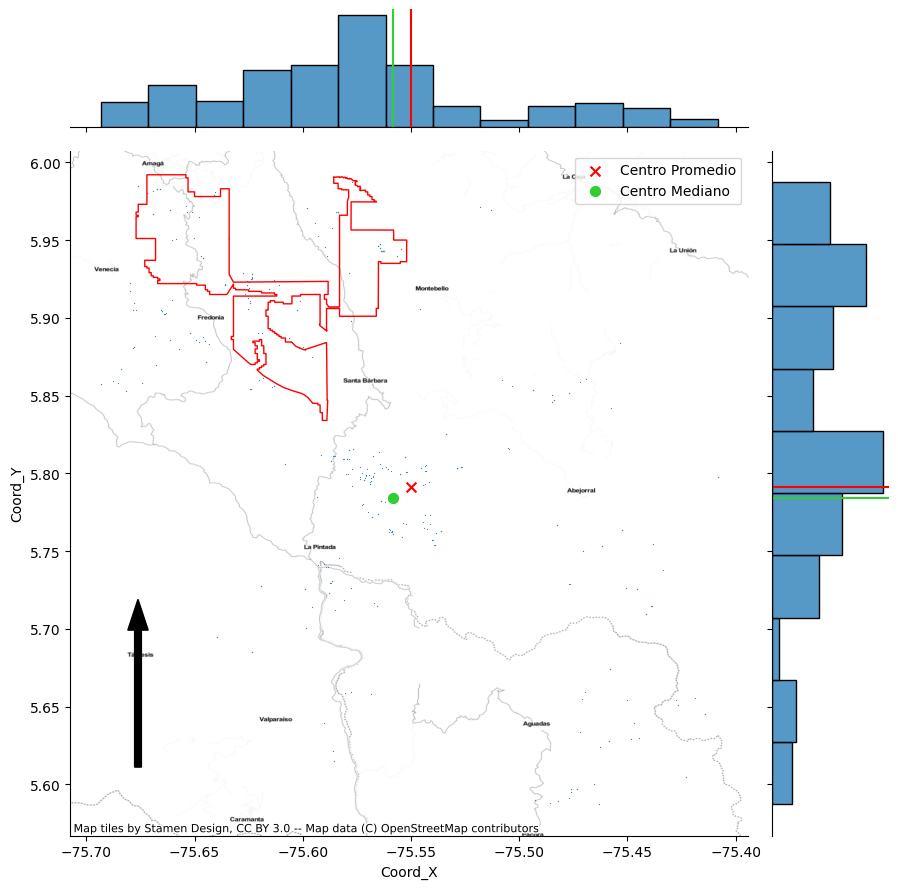

In [78]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from sklearn.cluster import KMeans

# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Leer el archivo shapefile
mtbll_nal = gpd.read_file(ruta_shp)
mtbll_nal = mtbll_nal.to_crs("EPSG:4326")

# Seleccionar las variables relevantes para el análisis de agrupamiento
data_selected = data[['Coord_X', 'Coord_Y']]

# Convertir los datos seleccionados a un arreglo de numpy
X = data_selected.values

# Definir el número de grupos deseados
k = 3

# Aplicar el algoritmo k-means
kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(X)

# Obtener los centroides de los grupos y las etiquetas asignadas a cada observación
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Calcular los centros promedio y medianos
mean_center = np.mean(centroids, axis=0)
med_center = np.median(centroids, axis=0)

# Generar el gráfico de dispersión
joint_axes = sns.jointplot(x='Coord_X', y='Coord_Y', data=data, s=0.75, height=9)

# Agregar el punto medio y las líneas marginales
joint_axes.ax_joint.scatter(*mean_center, color='red', marker='x', s=50, label='Centro Promedio')
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')

# Agregar el punto medio y las líneas marginales
joint_axes.ax_joint.scatter(*med_center, color='limegreen', marker='o', s=50, label='Centro Mediano')
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')

# Leyenda
joint_axes.ax_joint.legend()

# Agregar flecha que indica el norte
ax = joint_axes.ax_joint
ax.arrow(0.1, 0.1, 0, 0.2, width=0.01, transform=ax.transAxes, color='black')

# Obtener los límites de los ejes
x_min, x_max = joint_axes.ax_joint.get_xlim()
y_min, y_max = joint_axes.ax_joint.get_ylim()

# Ajustar los límites de los ejes para evitar desajustes
mtbll_nal.plot(ax=joint_axes.ax_joint, facecolor='none', edgecolor='red')
joint_axes.ax_joint.set_xlim(x_min, x_max)
joint_axes.ax_joint.set_ylim(y_min, y_max)

# Agregar el mapa base
ctx.add_basemap(joint_axes.ax_joint, crs="EPSG:4326", source=ctx.providers.Stamen.TonerLite, alpha=1.0, zoom=12)

# Establecer etiquetas de los ejes
joint_axes.ax_joint.set_xlabel('Coord_X')
joint_axes.ax_joint.set_ylabel('Coord_Y')

# Mostrar el gráfico
plt.imshow(joint_axes.ax_joint.get_images()[0].get_array(), extent=(x_min, x_max, y_min, y_max), aspect='auto')


plt.show()




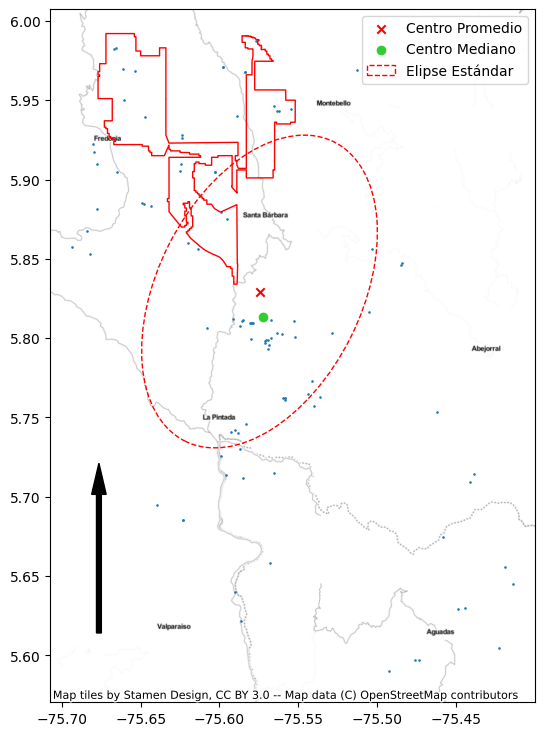

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import contextily as ctx

# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Leer el archivo shapefile
mtbll_nal = gpd.read_file(ruta_shp)
mtbll_nal = mtbll_nal.to_crs("EPSG:4326")
# Calcular el centro promedio y el centro mediano
mean_center = centrography.mean_center(data[['Coord_X', 'Coord_Y']])
med_center = centrography.euclidean_median(data[['Coord_X', 'Coord_Y']])

# Calcular los parámetros de la elipse estándar
major, minor, rotation = centrography.ellipse(data[['Coord_X', 'Coord_Y']])

# Desagrupamiento: Submuestreo aleatorio
n_samples = len(data)  # Número total de muestras
n_desired_samples = 100  # Número deseado de muestras después de la desagrupación
random_indices = np.random.choice(range(n_samples), size=n_desired_samples, replace=False)
desclustered_data = data.iloc[random_indices]

# Configurar la figura y el eje
f, ax = plt.subplots(1, figsize=(9, 9))

# Graficar los puntos fotográficos después de la desagrupación
ax.scatter(desclustered_data['Coord_X'], desclustered_data['Coord_Y'], s=0.75)

# Graficar el centro promedio y el centro mediano
ax.scatter(*mean_center, color='red', marker='x', label='Centro Promedio')
ax.scatter(*med_center, color='limegreen', marker='o', label='Centro Mediano')

# Construir la elipse estándar utilizando matplotlib
ellipse = Ellipse(xy=mean_center,
                  width=major*2,
                  height=minor*2,
                  angle=np.rad2deg(rotation),
                  facecolor='none',
                  edgecolor='red',
                  linestyle='--',
                  label='Elipse Estándar')
ax.add_patch(ellipse)

ax.legend()


# Agregar el mapa base
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Stamen.TonerLite, alpha=1.0, zoom=12)

ax.arrow(0.1, 0.1, 0, 0.2, width=0.01, transform=ax.transAxes, color='black')
# Mostrar el gráfico
mtbll_nal.plot(ax=ax, facecolor='none', edgecolor='red')

plt.show()


In [80]:
centrography.std_distance(data[['Coord_X','Coord_Y']])
major, minor, rotation = centrography.ellipse(data[['Coord_X','Coord_Y']])

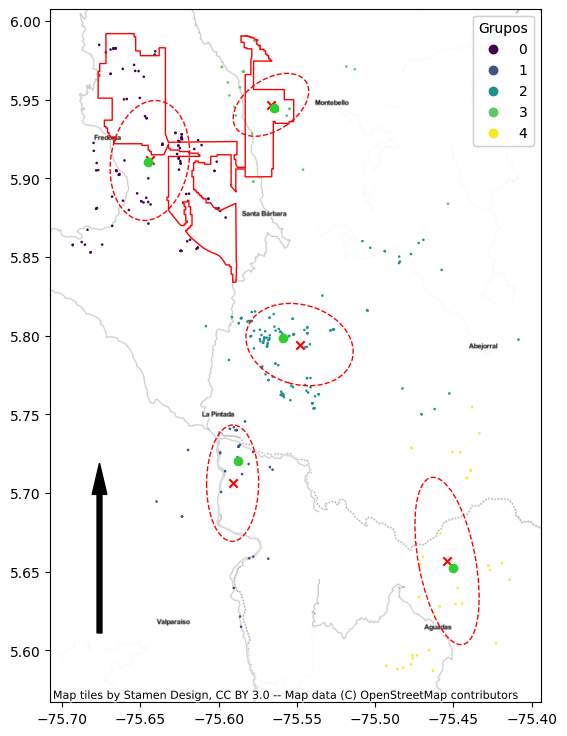

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import contextily as ctx
from sklearn.cluster import KMeans
# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Leer el archivo shapefile
mtbll_nal = gpd.read_file(ruta_shp)
mtbll_nal = mtbll_nal.to_crs("EPSG:4326")
# Realizar el agrupamiento utilizando KMeans
X = data[['Coord_X', 'Coord_Y']].values
kmeans = KMeans(n_clusters=5, n_init=10)  # Establecer n_init explícitamente
labels = kmeans.fit_predict(X)

# Obtener los centroides y las características de las elipses para cada grupo
centroids = kmeans.cluster_centers_
majors = []
minors = []
rotations = []
for i in range(len(centroids)):
    group_data = data[labels == i][['Coord_X', 'Coord_Y']]
    cov_matrix = np.cov(group_data.values.T)
    eigvals, eigvecs = np.linalg.eig(cov_matrix)
    major_axis = np.sqrt(eigvals[np.argmax(eigvals)])
    minor_axis = np.sqrt(eigvals[np.argmin(eigvals)])
    rotation_angle = np.arctan2(eigvecs[np.argmax(eigvals)][1], eigvecs[np.argmax(eigvals)][0])
    majors.append(major_axis)
    minors.append(minor_axis)
    rotations.append(rotation_angle)

# Calcular el centro promedio y la media para cada grupo
mean_centers = []
med_centers = []
for i in range(len(centroids)):
    group_data = data[labels == i][['Coord_X', 'Coord_Y']]
    mean_center = group_data.mean().values
    med_center = np.median(group_data.values, axis=0)
    mean_centers.append(mean_center)
    med_centers.append(med_center)

# Configurar la figura y el eje
f, ax = plt.subplots(1, figsize=(9, 9))

# Graficar los puntos fotográficos coloreando por grupos
scatter = ax.scatter(data['Coord_X'], data['Coord_Y'], c=labels, s=0.75, cmap='viridis')

# Graficar los centroides y las elipses para cada grupo
for centroid, major, minor, rotation, mean_center, med_center in zip(centroids, majors, minors, rotations, mean_centers, med_centers):
    ellipse = Ellipse(xy=centroid,
                      width=major*2,
                      height=minor*2,
                      angle=np.rad2deg(rotation),
                      facecolor='none',
                      edgecolor='red',
                      linestyle='--')
    ax.add_patch(ellipse)
    ax.scatter(*mean_center, color='red', marker='x', label='Centro Promedio')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Centro Media')

# Agregar el mapa base
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Stamen.TonerLite, alpha=1.0, zoom=12)

# Añadir la leyenda
legend1 = ax.legend(*scatter.legend_elements(), title='Grupos', loc='upper right')
ax.add_artist(legend1)
ax.arrow(0.1, 0.1, 0, 0.2, width=0.01, transform=ax.transAxes, color='black')
# Mostrar el gráfico
mtbll_nal.plot(ax=ax, facecolor='none', edgecolor='red')

plt.show()




/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


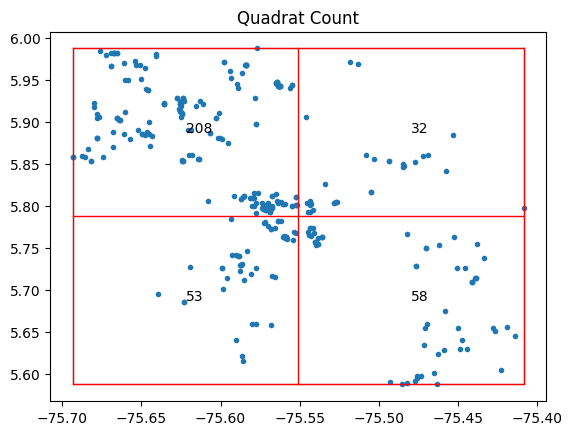

In [82]:
from pointpats import QStatistic, PointPattern

# Crear un objeto PointPattern con las coordenadas de tus puntos
coordinates = list(zip(data['Coord_X'], data['Coord_Y']))
point_pattern = PointPattern(coordinates)

# Calcular la estadística Q utilizando el objeto PointPattern
q_statistic = QStatistic(point_pattern, nx=2, ny=2)

# Visualizar los resultados
q_statistic.plot()




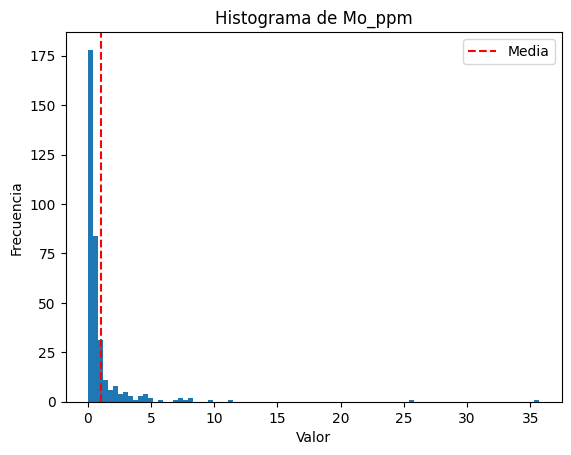

In [83]:
# Calcular la media de la columna 'Cu_ppm' y almacenarla en el objeto "mean"
mean = np.mean(data['Mo_ppm'])

# Calcular la mediana de la columna 'Cu_ppm' y almacenarla en el objeto "median"
median = np.median(data['Mo_ppm'])

# Calcular la desviación estándar de la columna 'Cu_ppm' y almacenarla en el objeto "std"
std = np.std(data['Mo_ppm'])

# Obtener el valor mínimo de la columna 'Cu_ppm' y almacenarlo en el objeto "min_value"
min_value = np.min(data['Mo_ppm'])

# Obtener el valor máximo de la columna 'Cu_ppm' y almacenarlo en el objeto "max_value"
max_value = np.max(data['Mo_ppm'])

# Crear un histograma de la columna 'Cu_ppm' con 90 bins
plt.hist(data['Mo_ppm'], bins=90)

# Establecer el título y etiquetas de los ejes del gráfico
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de Mo_ppm')

# Dibujar una línea vertical en la posición de la media con color rojo y estilo de línea discontinua
plt.axvline(mean, color='r', linestyle='--', label='Media')

# Mostrar la leyenda en el gráfico
plt.legend()

# Mostrar el gráfico
plt.show()

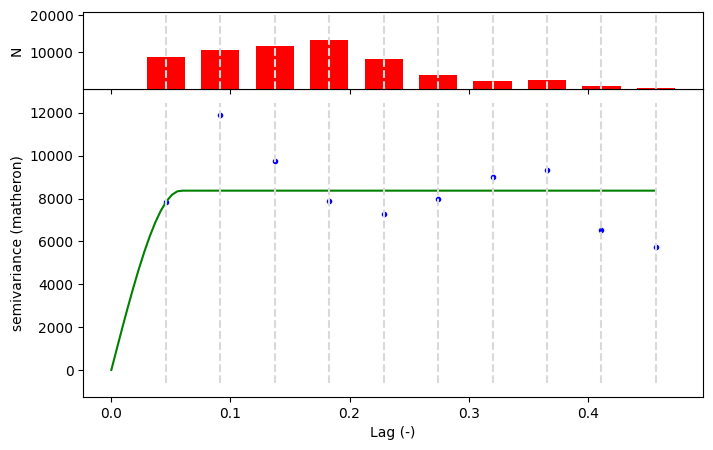

estimation_error 0.11961150858130432


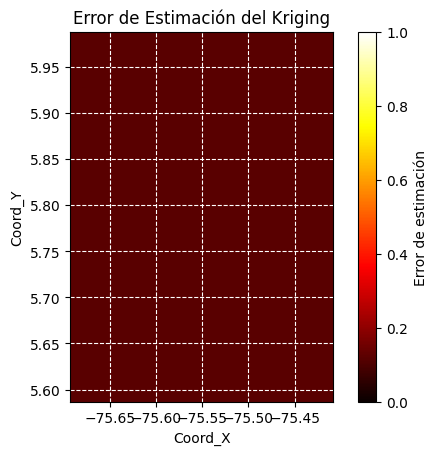

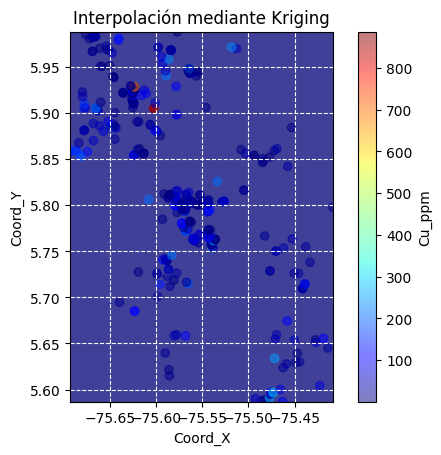

In [84]:
# Eliminar filas con valores faltantes
data_clean = data.dropna(subset=['Coord_X', 'Coord_Y', 'Cu_ppm'])
coords = data_clean[['Coord_X', 'Coord_Y']].values
values = data_clean['Cu_ppm'].values

# Escalar las coordenadas
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Calcular la matriz de distancias
distances = np.linalg.norm(coords_scaled[:, None] - coords_scaled, axis=2)

# Convertir los datos a matrices numpy
coords = np.asarray(coords)
values = np.asarray(values)

# Crear el objeto Variogram
variogram = Variogram(coordinates=coords, values=values, distances=distances, model='spherical')

# Calcular el variograma con semivarianzas
variogram.fit()

# Obtener los parámetros del variograma
sill = variogram.describe()['sill']
range_ = np.max(distances)
nugget = variogram.describe()['nugget']

# Graficar el variograma
variogram.plot()

plt.show()

# Crear el modelo de regresor de proceso gaussiano
kernel = RBF(length_scale_bounds=(1e-08, np.inf))

gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

# Ajustar el modelo a los datos
gpr.fit(coords_scaled, values)

# Definir la grilla de puntos para la interpolación
xmin, xmax = coords[:, 0].min(), coords[:, 0].max()
ymin, ymax = coords[:, 1].min(), coords[:, 1].max()
gridx = np.linspace(xmin, xmax, num=100)
gridy = np.linspace(ymin, ymax, num=100)
grid_coords = np.meshgrid(gridx, gridy)
grid_coords_scaled = np.vstack([grid_coords[0].flatten(), grid_coords[1].flatten()]).T

interpolated_values = gpr.predict(grid_coords_scaled)

# Calcular el error de estimación
estimation_error = 1 - gpr.score(coords_scaled, values)
print("estimation_error",estimation_error)
# Visualizar el mapa de errores
error_map = np.zeros((100, 100))
error_map.fill(estimation_error)

plt.imshow(error_map, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='hot', vmin=0, vmax=1)
plt.colorbar(label='Error de estimación')
plt.xlabel('Coord_X')
plt.ylabel('Coord_Y')
plt.title('Error de Estimación del Kriging')
plt.gca().set_facecolor('lightgray')  # Cambiar el color de fondo de la grilla
plt.grid(color='white', linestyle='--')  # Cambiar el color de las líneas de la grilla

plt.show()
#crea una vizualizacion de los valores interpolados y las coordenas
plt.imshow(interpolated_values.reshape(100, 100), origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='jet', alpha=0.7)
plt.scatter(coords[:, 0], coords[:, 1], c=values, cmap='jet', alpha=0.5)
plt.colorbar(label='Cu_ppm')
plt.xlabel('Coord_X')
plt.ylabel('Coord_Y')
plt.title('Interpolación mediante Kriging')
plt.gca().set_facecolor('lightgray')  # Cambiar el color de fondo de la grilla
plt.grid(color='white', linestyle='--')  # Cambiar el color de las líneas de la grilla
plt.show()


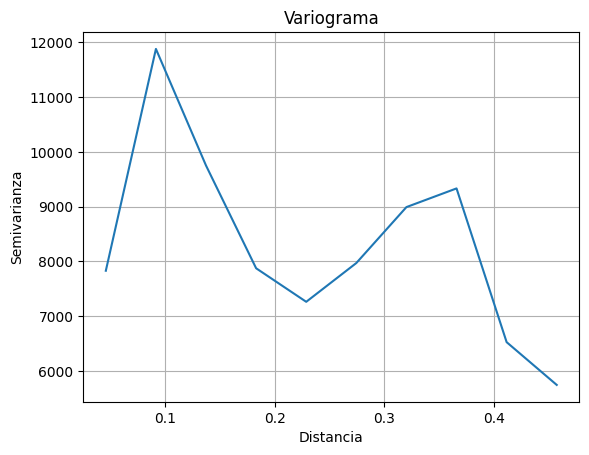

In [86]:
# Graficar los puntos experimentales del variograma
plt.plot(variogram.bins, variogram.experimental)

# Establecer las etiquetas de los ejes
plt.xlabel('Distancia')
plt.ylabel('Semivarianza')

# Establecer el título del gráfico
plt.title('Variograma')

# Activar la grilla en el gráfico
plt.grid(True)

# Mostrar el gráfico
plt.show()


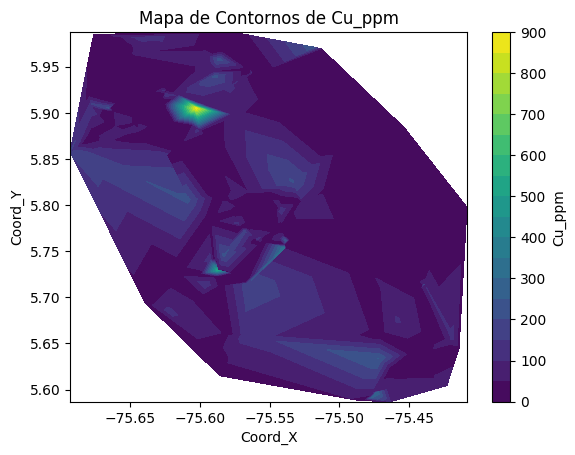

In [87]:
# Obtener los valores de las coordenadas transformadas
Coord_X = data['Coord_X']
Coord_Y = data['Coord_Y']

# Obtener los valores de Cu_ppm
Cu_ppm = data['Cu_ppm']

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear mapa de contornos con malla irregular
contour = ax.tricontourf(Coord_X, Coord_Y, Cu_ppm, levels=20, cmap='viridis')

# Agregar barra de color
plt.colorbar(contour, label='Cu_ppm')

# Personalizar el mapa de contornos
ax.set_xlabel('Coord_X')
ax.set_ylabel('Coord_Y')
ax.set_title('Mapa de Contornos de Cu_ppm')

# Mostrar el mapa de contornos
plt.show()

In [27]:
# Cargar el DataFrame desde un archivo Excel
data = pd.read_excel('datos_au_cu.xlsx')

# Definir el sistema de coordenadas de origen y destino
crs_wgs84 = pyproj.CRS('EPSG:4326')  # WGS84
crs_magna = pyproj.CRS('EPSG:9377')  # MAGNA Colombia (Origen Bogotá)

# Definir la transformación de coordenadas
transformer = pyproj.Transformer.from_crs(crs_wgs84, crs_magna, always_xy=True)

# Aplicar la transformación a las columnas Coord_X y Coord_Y
data['Coord_X'], data['Coord_Y'] = transformer.transform(data['Coord_X'], data['Coord_Y'])

# Redondear las coordenadas a dos decimales
data['Coord_X'] = data['Coord_X'].round(2)
data['Coord_Y'] = data['Coord_Y'].round(2)

# Imprimir el DataFrame con las coordenadas transformadas
print(data)

        Coord_X     Coord_Y  Cu_ppm  Au_ppm  Mo_ppm
0    4727243.70  2175929.71   91.00     0.2    0.22
1    4724749.34  2176055.28   17.20     0.2    4.12
2    4725138.48  2176163.55    4.50     0.5    0.31
3    4723966.84  2176295.51   49.30     0.2    0.13
4    4725694.79  2176380.49  252.00     0.3    0.69
..          ...         ...     ...     ...     ...
346  4704836.36  2219785.81    0.61     NaN    0.57
347  4704990.40  2219791.66    0.61     NaN    0.82
348  4704990.40  2219791.66   37.40     NaN    0.56
349  4703818.28  2220046.37    8.05     NaN    0.71
350  4714806.51  2220278.75    0.72     NaN    0.62

[351 rows x 5 columns]


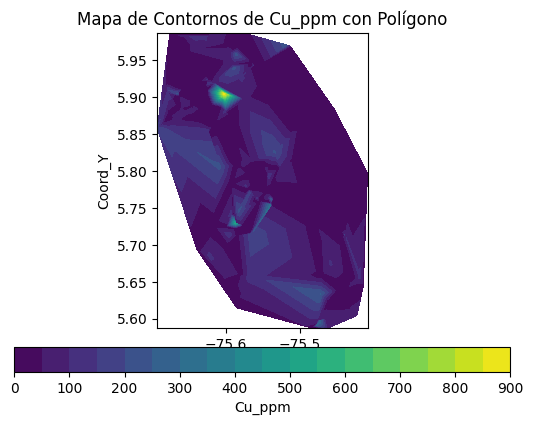

In [96]:
# Obtener los valores de las coordenadas transformadas
Coord_X = data['Coord_X']
Coord_Y = data['Coord_Y']

# Obtener los valores de Cu_ppm
Cu_ppm = data['Cu_ppm']

# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Cargar el archivo .shp como GeoDataFrame
poligono = gpd.read_file(ruta_shp)

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear mapa de contornos con malla irregular
contour = ax.tricontourf(Coord_X, Coord_Y, Cu_ppm, levels=20, cmap='viridis')

# Agregar el polígono al plot
poligono.plot(ax=ax, facecolor='none', edgecolor='red')

# Configurar los límites del eje
xmin, xmax = min(Coord_X), max(Coord_X)
ymin, ymax = min(Coord_Y), max(Coord_Y)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Personalizar el plot
ax.set_xlabel('Coord_X')
ax.set_ylabel('Coord_Y')
ax.set_title('Mapa de Contornos de Cu_ppm con Polígono')

# Agregar escala de barras
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Cu_ppm')

# Mostrar el plot
plt.show()

In [90]:
!pip install --upgrade fiona GDAL
!pip install geopandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.5/775.5 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for GDAL
  Running setup.py clean for GDAL
Failed to build GDAL
ERROR: Could not build wheels for GDAL, which is required to install pyproject.toml-based projects


In [91]:
!pip install --upgrade fiona


Text(0.5, 1.0, 'Polígono')

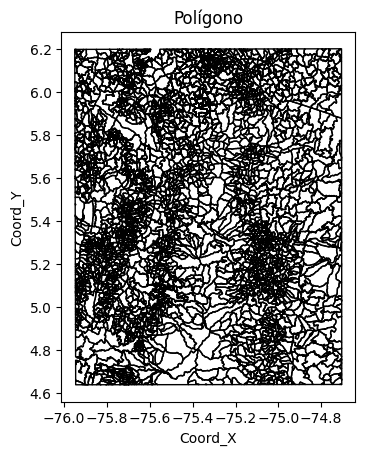

In [97]:
import matplotlib.pyplot as plt


# Ruta del archivo .shp del polígono
ruta_shp = '/content/clip_veredas.shp'

# Leer el archivo shapefile
poligono = gpd.read_file(ruta_shp)


# Crear figura y ejes
fig, ax = plt.subplots()

# Agregar el polígono al plot
poligono.plot(ax=ax, facecolor='none', edgecolor='black')

# Personalizar el plot
plt.xlabel('Coord_X')
plt.ylabel('Coord_Y')
plt.title('Polígono')



/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


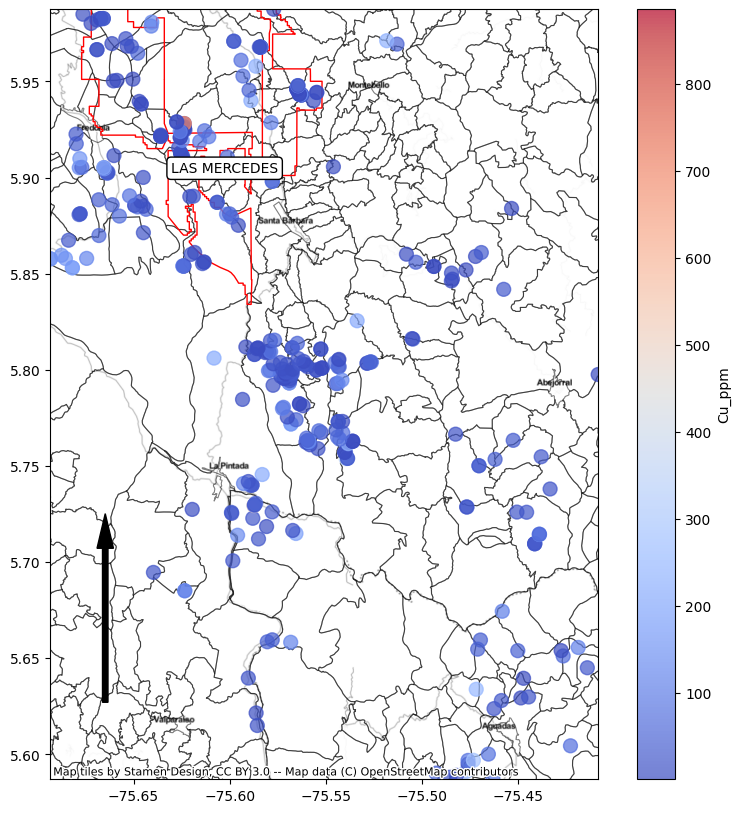

In [98]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Leer los datos de cobre
data = pd.read_excel('datos_au_cu.xlsx')

# Ruta del archivo .shp del polígono
ruta_shps = '/content/clip_veredas.shp'
# Leer el archivo de forma (shapefile) del polígono
poligono = gpd.read_file(ruta_shps)

# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Leer el archivo shapefile
mtbll_nal = gpd.read_file(ruta_shp)
mtbll_nal = mtbll_nal.to_crs("EPSG:4326")



# Unir los datos de cobre y el polígono basado en las coordenadas
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['Coord_X'], data['Coord_Y']))
data_gdf = data_gdf.set_crs("EPSG:4326")  # Establecer el CRS de los datos a WGS84 si es necesario
poligono = poligono.to_crs(data_gdf.crs)  # Reproyectar el polígono al CRS de los datos de cobre

data_poligono = gpd.sjoin(data_gdf, poligono, op='within')

# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots(figsize=(10, 10))



# Dibujar los polígonos del polígono con transparencia
poligono.plot(facecolor='none', edgecolor='black', linewidth=0.8, alpha=0.5, ax=ax)
mtbll_nal.plot(ax=ax, facecolor='none', edgecolor='red')
# Generar el mapa de calor utilizando scatter() en lugar de plot()
sc = ax.scatter(data_poligono['Coord_X'], data_poligono['Coord_Y'], c=data_poligono['Cu_ppm'], cmap='coolwarm', s=100, alpha=0.7)

# Añadir una barra de color para la leyenda
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Cu_ppm')
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Stamen.TonerLite, alpha=1.0, zoom=12)
# Establecer los límites de los ejes X e Y para hacer zoom a los datos
ax.set_xlim(data_poligono['Coord_X'].min(), data_poligono['Coord_X'].max())
ax.set_ylim(data_poligono['Coord_Y'].min(), data_poligono['Coord_Y'].max())

# Agregar una flecha que indica el norte
ax.arrow(0.1, 0.1, 0, 0.2, width=0.01, transform=ax.transAxes, color='black')


# Obtener la ubicación con el mayor valor de Cu_ppm
max_value_location = data_poligono.loc[data_poligono['Cu_ppm'].idxmax()]

# Obtener el nombre de la vereda correspondiente a la ubicación
vereda_name = max_value_location['NOMBRE_VER']

# Agregar la etiqueta con el nombre de la vereda y fondo blanco
ax.text(max_value_location['Coord_X'], max_value_location['Coord_Y'], vereda_name,
        fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

# Mostrar el gráfico
plt.show()






In [99]:
import pandas as pd
import geopandas as gpd



# Ruta del archivo .shp del polígono
ruta = '/content/clip_veredas.shp'

# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Leer el archivo shapefile
mtbll_nal = gpd.read_file(ruta_shp)
mtbll_nal = mtbll_nal.to_crs("EPSG:4326")

# Leer los datos de las veredas (polígonos)
veredas = gpd.read_file(ruta)

# Leer los datos de cobre (puntos)
data = pd.read_excel('datos_au_cu.xlsx')

# Convertir los datos de cobre a un GeoDataFrame y definir el CRS
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['Coord_X'], data['Coord_Y']))
data_gdf.crs = 'EPSG:4686'  # Definir el CRS de los datos de cobre según corresponda

# Realizar una unión espacial (sjoin) entre los datos de cobre y las veredas
data_veredas = gpd.sjoin(data_gdf, veredas, how='left', op='within')

# Calcular el recuento de puntos de Cu_ppm por vereda
recuento_cu_ppm = data_veredas.groupby('NOMBRE_VER')['Cu_ppm'].count()

# Agregar el recuento de puntos de Cu_ppm como una columna en el GeoDataFrame de las veredas
veredas['recuento_cu_ppm'] = veredas['NOMBRE_VER'].map(recuento_cu_ppm).fillna(0).astype(int)





/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<ipython-input-100-b60aa9f2516f>:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vereda_mayor_x = veredas_filtradas.loc[veredas_filtradas['NOMBRE_VER'] == vereda_mayor_recuento, 'geometry'].centroid.x.values[0]
<ipython-input-100-b60aa9f2516f>:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vereda_mayor_y = veredas_filtradas.loc[veredas_filtradas['NOMBRE_VER'] == vereda_mayor_recuento, 'geometry'].centroid.y.values[0]


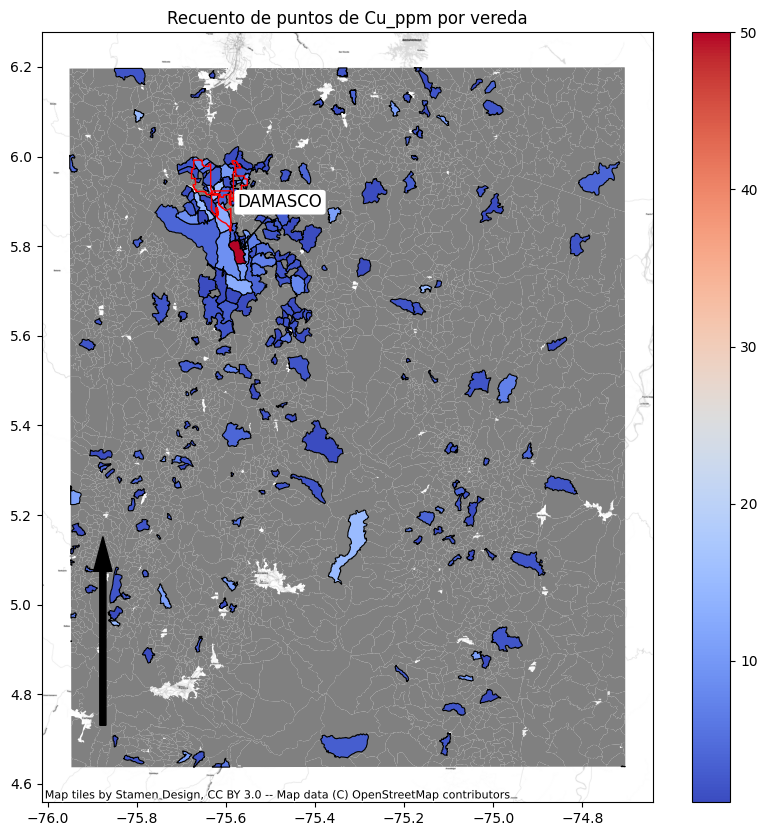

In [100]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Leer el archivo shapefile de las veredas
veredas = gpd.read_file(ruta)

# Agregar el recuento de puntos de Cu_ppm como una columna en el GeoDataFrame de las veredas
veredas['recuento_cu_ppm'] = veredas['NOMBRE_VER'].map(recuento_cu_ppm).fillna(0).astype(int)

# Filtrar las veredas con recuento de puntos mayor a cero
veredas_filtradas = veredas[veredas['recuento_cu_ppm'] > 0]

# Obtener el nombre de la vereda con la mayor cantidad de puntos de Cu_ppm
vereda_mayor_recuento = veredas_filtradas.loc[veredas_filtradas['recuento_cu_ppm'].idxmax(), 'NOMBRE_VER']

# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar el GeoDataFrame de todas las veredas con color gris
veredas.plot(color='gray', linewidth=0.8, ax=ax)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Stamen.TonerLite, alpha=1.0, zoom=12)

# Graficar el GeoDataFrame de las veredas filtradas con el mapa de calor
veredas_filtradas.plot(column='recuento_cu_ppm', cmap='coolwarm', linewidth=0.8, ax=ax, alpha=1.0, edgecolor='black', legend=True)
mtbll_nal.plot(ax=ax, facecolor='none', edgecolor='red')

# Añadir título al gráfico
ax.set_title('Recuento de puntos de Cu_ppm por vereda')

# Agregar etiqueta a la vereda con mayor recuento
vereda_mayor_x = veredas_filtradas.loc[veredas_filtradas['NOMBRE_VER'] == vereda_mayor_recuento, 'geometry'].centroid.x.values[0]
vereda_mayor_y = veredas_filtradas.loc[veredas_filtradas['NOMBRE_VER'] == vereda_mayor_recuento, 'geometry'].centroid.y.values[0]
ax.annotate(vereda_mayor_recuento, xy=(vereda_mayor_x, vereda_mayor_y), xytext=(vereda_mayor_x, vereda_mayor_y+0.1),
             arrowprops=dict(arrowstyle='->'), color='black', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))


# Agregar una flecha que indica el norte
ax.arrow(0.1, 0.1, 0, 0.2, width=0.01, transform=ax.transAxes, color='black')

# Mostrar el gráfico
plt.show()




In [101]:
!pip install mplleaflet


  Preparing metadata (setup.py) ... done
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28565 sha256=8ac07703a9c7303d0ca1f02cb1a4ce7293bcb30ac8e17a378cd092d6cc61be26
  Stored in directory: /root/.cache/pip/wheels/0d/00/a9/595e650d2e0a5ca4119c0f6e03dfd1093e5d67fe2c0e5d49f0
Successfully built mplleaflet


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


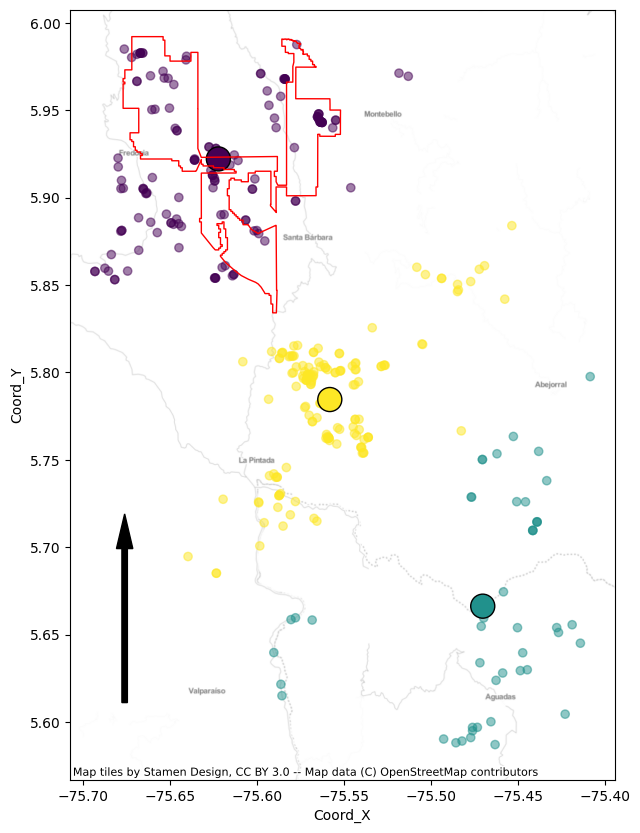

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import contextily as ctx

# Leer los datos desde el archivo excel
data = pd.read_excel('datos_au_cu.xlsx')



# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Leer el archivo shapefile
mtbll_nal = gpd.read_file(ruta_shp)
mtbll_nal = mtbll_nal.to_crs("EPSG:4326")

# Seleccionar las variables relevantes para el análisis de agrupamiento
data_selected = data[['Coord_X', 'Coord_Y']]

# Obtener las coordenadas de los datos
coordinates = data_selected.values

# Definir el número de clusters
k = 3

# Aplicar el algoritmo k-means
kmeans = KMeans(n_clusters=k, random_state=123)
labels = kmeans.fit_predict(coordinates)
centroids = kmeans.cluster_centers_

# Colores para los clusters
colors = ['blue', 'green', 'red']

# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar los puntos y los centroides
scatter = ax.scatter(data_selected['Coord_X'], data_selected['Coord_Y'], marker='o', c=labels, cmap='viridis', alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=300, c=range(k), cmap='viridis', edgecolors='black')
ax.set_xlabel('Coord_X')
ax.set_ylabel('Coord_Y')

# Agregar el mapa base utilizando contextily
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Stamen.TonerLite, alpha=0.5)
mtbll_nal.plot(ax=ax, facecolor='none', edgecolor='red')
# Agregar una flecha que indica el norte
ax.arrow(0.1, 0.1, 0, 0.2, width=0.01, transform=ax.transAxes, color='black')

# Mostrar el gráfico
plt.show()




In [104]:
!pip install rasterio
!pip install earthpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.0 MB/s eta 0:00:00


In [8]:
import rasterio

# Ruta relativa al archivo dentro de Colab
file_path = '/content/drive/MyDrive/Colab_Notebooks/AP_26112_FBS_F0100_RT1_reprojected.tif'

# Abre el archivo raster
with rasterio.open(file_path) as file:
    # Lee los datos del archivo raster
          dataset = file.read()

# Imprime la forma de los datos del raster
print(dataset.shape)

(1, 5747, 6358)


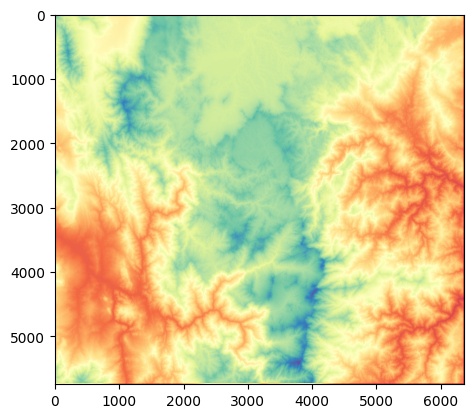

In [9]:
plt.imshow(dataset[0], cmap='Spectral')
plt.show()

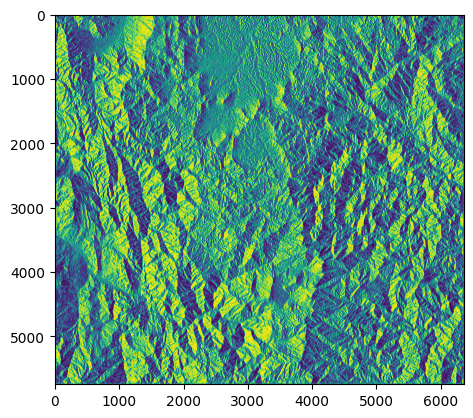

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy.spatial as es


# Calcular el sombreado
hillshade = es.hillshade(dataset[0], azimuth=270, altitude=1)

# Mostrar la imagen de sombreado
plt.imshow(hillshade)

# Mostrar el gráfico
plt.show()


In [11]:
!pip install pysal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.2/220.2 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
import statsmodels.api as sm
import pandas as pd

# Crear un DataFrame con las variables Mo_ppm y Cu_ppm
data = pd.DataFrame({'Cu_ppm': Cu_ppm, 'Mo_ppm': Mo_ppm})

# Ajustar el modelo de regresión con  Cu_ppm  como variable dependiente y Mo_ppm como variable independiente
model = sm.OLS(data['Cu_ppm'], sm.add_constant(data['Mo_ppm']))  # Agrega una constante al modelo
results = model.fit()

# Imprimir los resultados del modelo
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 Cu_ppm   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4712
Date:                Fri, 30 Jun 2023   Prob (F-statistic):              0.493
Time:                        02:02:03   Log-Likelihood:                -2093.6
No. Observations:                 351   AIC:                             4191.
Df Residuals:                     349   BIC:                             4199.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.9100      5.425     10.306      0.0

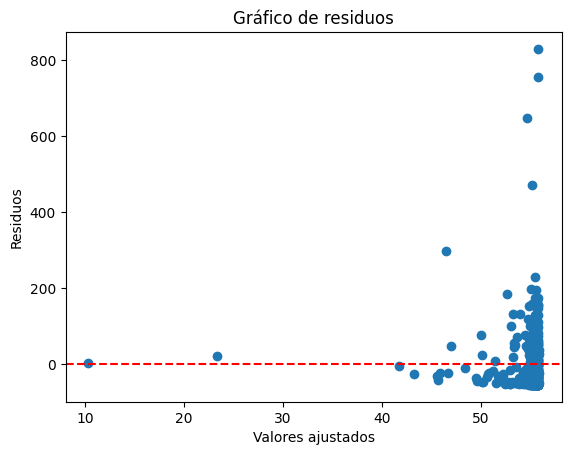

In [18]:
import matplotlib.pyplot as plt

# Calcular los residuos
residuals = results.resid

# Graficar los residuos
plt.scatter(results.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos')
plt.show()

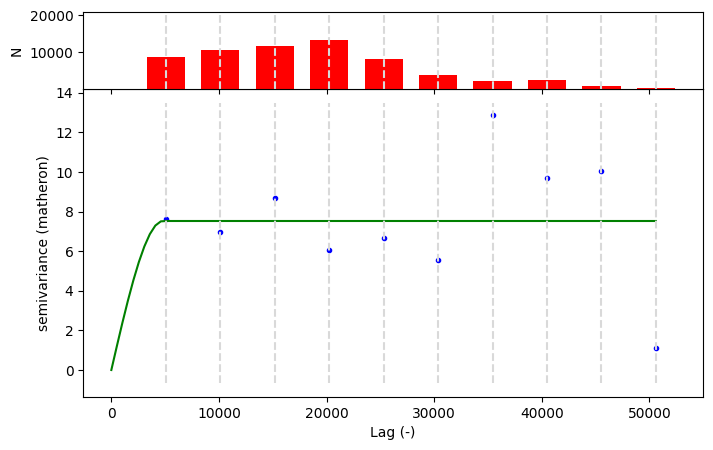

estimation_error 0.022603325489982784


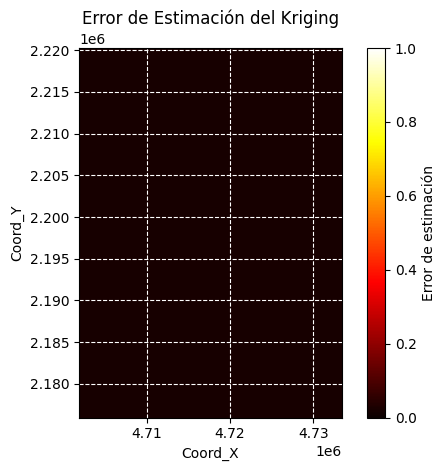

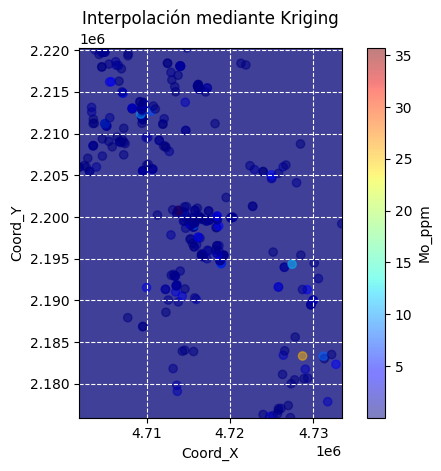

In [28]:
# Eliminar filas con valores faltantes
data_clean = data.dropna(subset=['Coord_X', 'Coord_Y', 'Mo_ppm'])
coords = data_clean[['Coord_X', 'Coord_Y']].values
values = data_clean['Mo_ppm'].values

# Escalar las coordenadas
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Calcular la matriz de distancias
distances = np.linalg.norm(coords_scaled[:, None] - coords_scaled, axis=2)

# Convertir los datos a matrices numpy
coords = np.asarray(coords)
values = np.asarray(values)

# Crear el objeto Variogram
variogram = Variogram(coordinates=coords, values=values, distances=distances, model='spherical')

# Calcular el variograma con semivarianzas
variogram.fit()

# Obtener los parámetros del variograma
sill = variogram.describe()['sill']
range_ = np.max(distances)
nugget = variogram.describe()['nugget']

# Graficar el variograma
variogram.plot()

plt.show()

# Crear el modelo de regresor de proceso gaussiano
kernel = RBF(length_scale_bounds=(1e-08, np.inf))

gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

# Ajustar el modelo a los datos
gpr.fit(coords_scaled, values)

# Definir la grilla de puntos para la interpolación
xmin, xmax = coords[:, 0].min(), coords[:, 0].max()
ymin, ymax = coords[:, 1].min(), coords[:, 1].max()
gridx = np.linspace(xmin, xmax, num=100)
gridy = np.linspace(ymin, ymax, num=100)
grid_coords = np.meshgrid(gridx, gridy)
grid_coords_scaled = np.vstack([grid_coords[0].flatten(), grid_coords[1].flatten()]).T

interpolated_values = gpr.predict(grid_coords_scaled)

# Calcular el error de estimación
estimation_error = 1 - gpr.score(coords_scaled, values)
print("estimation_error",estimation_error)
# Visualizar el mapa de errores
error_map = np.zeros((100, 100))
error_map.fill(estimation_error)

plt.imshow(error_map, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='hot', vmin=0, vmax=1)
plt.colorbar(label='Error de estimación')
plt.xlabel('Coord_X')
plt.ylabel('Coord_Y')
plt.title('Error de Estimación del Kriging')
plt.gca().set_facecolor('lightgray')  # Cambiar el color de fondo de la grilla
plt.grid(color='white', linestyle='--')  # Cambiar el color de las líneas de la grilla

plt.show()
#crea una vizualizacion de los valores interpolados y las coordenas
plt.imshow(interpolated_values.reshape(100, 100), origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='jet', alpha=0.7)
plt.scatter(coords[:, 0], coords[:, 1], c=values, cmap='jet', alpha=0.5)
plt.colorbar(label='Mo_ppm')
plt.xlabel('Coord_X')
plt.ylabel('Coord_Y')
plt.title('Interpolación mediante Kriging')
plt.gca().set_facecolor('lightgray')  # Cambiar el color de fondo de la grilla
plt.grid(color='white', linestyle='--')  # Cambiar el color de las líneas de la grilla

plt.show()

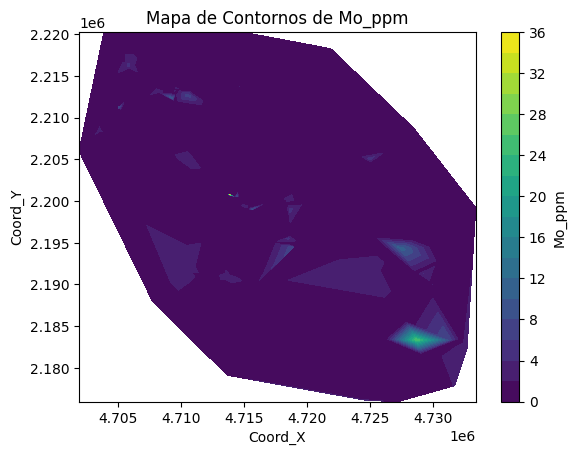

In [29]:
# Obtener los valores de las coordenadas transformadas
Coord_X = data['Coord_X']
Coord_Y = data['Coord_Y']

# Obtener los valores de Cu_ppm
Cu_ppm = data['Mo_ppm']

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear mapa de contornos con malla irregular
contour = ax.tricontourf(Coord_X, Coord_Y, Mo_ppm, levels=20, cmap='viridis')

# Agregar barra de color
plt.colorbar(contour, label='Mo_ppm')

# Personalizar el mapa de contornos
ax.set_xlabel('Coord_X')
ax.set_ylabel('Coord_Y')
ax.set_title('Mapa de Contornos de Mo_ppm')
# Mostrar el mapa de contornos
plt.show()

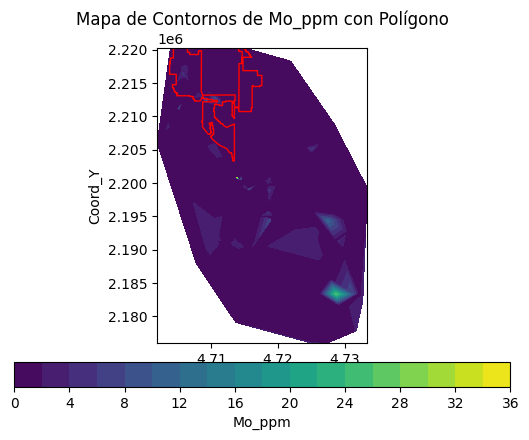

In [30]:
# Obtener los valores de las coordenadas transformadas
Coord_X = data['Coord_X']
Coord_Y = data['Coord_Y']

# Obtener los valores de Cu_ppm
Cu_ppm = data['Mo_ppm']

# Ruta del archivo .shp del polígono
ruta_shp = '/content/mtbll_nal.shp'

# Cargar el archivo .shp como GeoDataFrame
poligono = gpd.read_file(ruta_shp)

# Crear figura y ejes
fig, ax = plt.subplots()

# Crear mapa de contornos con malla irregular
contour = ax.tricontourf(Coord_X, Coord_Y, Cu_ppm, levels=20, cmap='viridis')

# Agregar el polígono al plot
poligono.plot(ax=ax, facecolor='none', edgecolor='red')

# Configurar los límites del eje
xmin, xmax = min(Coord_X), max(Coord_X)
ymin, ymax = min(Coord_Y), max(Coord_Y)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Personalizar el plot
ax.set_xlabel('Coord_X')
ax.set_ylabel('Coord_Y')
ax.set_title('Mapa de Contornos de Mo_ppm con Polígono')

# Agregar escala de barras
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Mo_ppm')

# Mostrar el plot
plt.show()